In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date    3650 non-null datetime64[ns]
Temp    3650 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null datetime64[ns]
Temperature    3650 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB
None

        date  min_temp  max_temp
0 1981-01-01      20.7      38.1
1 1981-01-02      17.9      32.4
2 1981-01-03      18.8      34.5
3 1981-01-04      14.6      20.7
4 1981-01-05      15.8      21.5

Minimum / Maximum average temperatures: 11.178 / 20.009151
Minimum / Maximum temperature standard deviations: 4.072 / 6.108353

Standard deviation by year
      min_temp  max_temp
year                    
1981  4.337430  6.581775
1982  4.806858  6.894386
1983  4.187325  6.315571
1984  3.733946  5.503548
1985

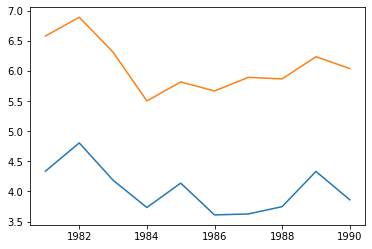

In [2]:
# open and combine datasets
min_temp_df = pd.read_csv('tmp/daily-min-temperatures.csv')
max_temp_df = pd.read_csv('tmp/daily-max-temperatures.csv')

min_temp_df['Date'] = pd.to_datetime(min_temp_df['Date'], errors = 'coerce')
max_temp_df['Date'] = pd.to_datetime(max_temp_df['Date'], errors = 'coerce')

print(min_temp_df.info())
print()
print(max_temp_df.info())
print()
temp_df = min_temp_df.merge(max_temp_df)
temp_df.columns = ['date', 'min_temp', 'max_temp']
print(temp_df.head())
print()

# checkout the data
print('Minimum / Maximum average temperatures: {:.3f} / {:3f}'
      .format(temp_df['min_temp'].mean(), temp_df['max_temp'].mean()))

# standard deviation of maximum temperatures are much higher
# expect higher errors in max temperature predictions
print('Minimum / Maximum temperature standard deviations: {:.3f} / {:3f}'
      .format(temp_df['min_temp'].std(), temp_df['max_temp'].std()))

print()
temp_df['year'] = temp_df['date'].apply(lambda x: x.year)
grouped_df = temp_df.groupby('year').agg({'min_temp': np.std, 'max_temp': np.std})
print('Standard deviation by year')
print(grouped_df)
plt.plot(grouped_df)

In [3]:
columns = ['min_temp', 'max_temp'] 
time = temp_df['date'].to_numpy()
series = temp_df[columns].to_numpy().astype(float)
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 8
batch_size = 50
shuffle_buffer_size = 1000
# add shift to predict multiple time steps
shift = 3
print(x_train.shape)
print(x_valid.shape)

(2500, 2)
(1150, 2)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # No need to expand dims in multivariate
    # series_dim is greater than one so python will not create rank-1 array
    # Before we had to change the (2500,) array to (2500,1) array
    # Since we start with more than one feature, we'll already have (2500,2)
    #series = tf.expand_dims(series, axis = -1)
    # replace 1 with shift
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + shift, shift = shift, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + shift))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda w: (w[:-shift], w[-shift:]))
    return dataset.batch(batch_size).prefetch(shift)

In [5]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = shift, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(shift)
    forecast = model.predict(dataset)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
series_dim = len(columns)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
x, y = next(iter(train_set))
print(x.shape)
print(y.shape)

model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv1D(filters = 50, kernel_size = 5, strides = 1, padding = 'causal', 
    #                       activation = 'relu', input_shape = [window_size, series_dim]),
    #tf.keras.layers.MaxPooling1D(2, 2),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size, series_dim]),
    tf.keras.layers.LSTM(50, activation = 'relu', input_shape = [window_size, series_dim]),
    # repeat vector for the number of look forward periods in shift
    tf.keras.layers.RepeatVector(shift),
    tf.keras.layers.LSTM(50, activation = 'relu', return_sequences = True),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dense(50, activation = 'relu'),
    #tf.keras.layers.Dense(3, activation = 'relu'),
    #tf.keras.layers.LSTM(2, return_sequences = True, input_shape = [None, shift, series_dim])
    # Two outputs per time step (min and mz temp)
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(series_dim))
    #tf.keras.layers.Lambda(lambda x: x * 100)
])
model.summary()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


<PrefetchDataset shapes: ((None, None, 2), (None, None, 2)), types: (tf.float64, tf.float64)>
(2500, 2)
(50, 8, 2)
(50, 3, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 2)              102       
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
17/17 [==============================] - 2s 93ms/step - loss: 14.4312 - mae: 14.9313
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 14.4291 - mae: 14.9292
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 14.4262 - mae: 14.9264
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 14.4229 - mae: 14.9231
Epoch 5/100
17/17 [==============================] - 0s 12ms/step - loss: 14.4193 - mae: 14.9194
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 14.4151 - mae: 14.9153
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 14.4105 - mae: 14.9107
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 14.4053 - mae: 14.9056
Epoch 9/100
17/17 [==============================] - 0s 10ms/step - loss: 14.3995 - mae: 14.8999
Epoch 10/100
17/17 [==============================] - 0s 12ms/step - loss: 14.3931 - mae: 14.8935
Epoch 11/100
17/17 [=========

17/17 [==============================] - 0s 12ms/step - loss: 2.3028 - mae: 2.7591
Epoch 86/100
17/17 [==============================] - 0s 11ms/step - loss: 2.3077 - mae: 2.7629
Epoch 87/100
17/17 [==============================] - 0s 11ms/step - loss: 2.3424 - mae: 2.7996
Epoch 88/100
17/17 [==============================] - 0s 10ms/step - loss: 2.2915 - mae: 2.7450
Epoch 89/100
17/17 [==============================] - 0s 12ms/step - loss: 2.2929 - mae: 2.7483
Epoch 90/100
17/17 [==============================] - 0s 12ms/step - loss: 2.2741 - mae: 2.7295
Epoch 91/100
17/17 [==============================] - 0s 10ms/step - loss: 2.2701 - mae: 2.7251
Epoch 92/100
17/17 [==============================] - 0s 12ms/step - loss: 2.2536 - mae: 2.7083
Epoch 93/100
17/17 [==============================] - 0s 11ms/step - loss: 2.2651 - mae: 2.7190
Epoch 94/100
17/17 [==============================] - 0s 12ms/step - loss: 2.2481 - mae: 2.7022
Epoch 95/100
17/17 [==============================] -

[1e-08, 0.0001, 0, 60]

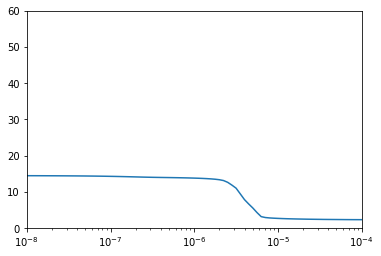

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = (windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, 
                              shuffle_buffer=shuffle_buffer_size))
model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv1D(filters = 50, kernel_size = 5, strides = 1, padding = 'causal', 
    #                       activation = 'relu', input_shape = [window_size, series_dim]),
    #tf.keras.layers.MaxPooling1D(2, 2),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size, series_dim]),
    tf.keras.layers.LSTM(50, activation = 'relu', input_shape = [window_size, series_dim]),
    tf.keras.layers.RepeatVector(shift),
    tf.keras.layers.LSTM(50, activation = 'relu', return_sequences = True),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dense(50, activation = 'relu'),
    #tf.keras.layers.Dense(3, activation = 'relu'),
    #tf.keras.layers.LSTM(2, return_sequences = True, input_shape = [None, shift, series_dim])
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(series_dim))
    #tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
17/17 [==============================] - 2s 93ms/step - loss: 13.0205 - mae: 13.6178
Epoch 2/150
17/17 [==============================] - 0s 12ms/step - loss: 3.8542 - mae: 4.3578
Epoch 3/150
17/17 [==============================] - 0s 12ms/step - loss: 2.5053 - mae: 2.9613
Epoch 4/150
17/17 [==============================] - 0s 11ms/step - loss: 2.3947 - mae: 2.8514
Epoch 5/150
17/17 [==============================] - 0s 12ms/step - loss: 2.3393 - mae: 2.7941
Epoch 6/150
17/17 [==============================] - 0s 11ms/step - loss: 2.3255 - mae: 2.7826
Epoch 7/150
17/17 [==============================] - 0s 10ms/step - loss: 2.3023 - mae: 2.7582
Epoch 8/150
17/17 [==============================] - 0s 12ms/step - loss: 2.2751 - mae: 2.7297
Epoch 9/150
17/17 [==============================] - 0s 11ms/step - loss: 2.2611 - mae: 2.7151
Epoch 10/150
17/17 [==============================] - 0s 12ms/step - loss: 2.2492 - mae: 2.7028
Epoch 11/150
17/17 [===========================

17/17 [==============================] - 0s 11ms/step - loss: 2.1161 - mae: 2.5703
Epoch 87/150
17/17 [==============================] - 0s 12ms/step - loss: 2.1156 - mae: 2.5698
Epoch 88/150
17/17 [==============================] - 0s 12ms/step - loss: 2.1152 - mae: 2.5693
Epoch 89/150
17/17 [==============================] - 0s 10ms/step - loss: 2.1146 - mae: 2.5687
Epoch 90/150
17/17 [==============================] - 0s 12ms/step - loss: 2.1134 - mae: 2.5676
Epoch 91/150
17/17 [==============================] - 0s 11ms/step - loss: 2.1120 - mae: 2.5662
Epoch 92/150
17/17 [==============================] - 0s 11ms/step - loss: 2.1117 - mae: 2.5659
Epoch 93/150
17/17 [==============================] - 0s 12ms/step - loss: 2.1124 - mae: 2.5665
Epoch 94/150
17/17 [==============================] - 0s 11ms/step - loss: 2.1125 - mae: 2.5666
Epoch 95/150
17/17 [==============================] - 0s 11ms/step - loss: 2.1110 - mae: 2.5652
Epoch 96/150
17/17 [==============================] -

In [11]:
# predict last min and max temperatures in the last three time steps
print(temp_df.tail(11))
x_input = (temp_df[-11:-3][columns].values).reshape(1, window_size, series_dim)
print()
print(model.predict(x_input))

           date  min_temp  max_temp  year
3639 1990-12-21      13.1      23.5  1990
3640 1990-12-22      13.2      30.3  1990
3641 1990-12-23      13.9      19.8  1990
3642 1990-12-24      10.0      23.3  1990
3643 1990-12-25      12.9      29.3  1990
3644 1990-12-26      14.6      20.9  1990
3645 1990-12-27      14.0      37.6  1990
3646 1990-12-28      13.6      23.2  1990
3647 1990-12-29      13.5      25.1  1990
3648 1990-12-30      15.7      24.4  1990
3649 1990-12-31      13.0      24.6  1990

[[[13.462474 21.63327 ]
  [14.045854 22.652143]
  [13.990785 23.06838 ]]]
